In [1]:
import os
import json
from itertools import chain, combinations, groupby
from functools import reduce
from textwrap import wrap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import entropy

In [3]:
import torch
from torch.utils.data import DataLoader

In [4]:
from pytorch_datasets import Ben19Dataset
from pytorch_models import ResNet18
from pytorch_utils import start_cuda, get_classification_report, print_micro_macro
from pytorch_utils import MetricTracker, init_results, update_results

## Notice
This script for analyzing data and the predictions/embeddings of a model learned to generalize on the data can be executed for any kind of data. For most of the analysis a model trained on a subset (e.g. Ireland Train) of BEN19 needs to be loaded. With it prediction and embedding values are extracted, that are later used for visualization. The pure label analysis can be also done without a pretrained model.

## Parameters, Dataset & Dataloader

In [5]:
with open('/workspace/datasets/BEN19/label_indices.json') as json_file:
    label_indices = json.load(json_file)

In [6]:
class_names = np.array(list(label_indices['BigEarthNet-19_labels'].keys()))
class_names_wrapped = list(map(lambda x: '\n'.join(wrap(x, width=30)), class_names))

In [7]:
# path to LMDB file of all BEN19 patches
lmdb_path = '/workspace/datasets/BEN19/BEN19.lmdb'
# csv paths to train & val file belonging to ireland
csv_path = '/workspace/datasets/BEN19/splits/ireland/test.csv'
# path to model pretrained on BEN19 ireland
model_path = '/workspace/models/ben19_ireland_model.pth'

In [8]:
cuda_no = 1
batch_size = 128
num_workers = 8
epochs = 30

channels = 10
num_classes = 19
dataset_filter = 'ireland'

In [9]:
dataset = Ben19Dataset(lmdb_path=lmdb_path, csv_path=csv_path, img_transform='default')
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                        shuffle=True, pin_memory=True)

## Load pretrained model and evaluate predictions and embeddings

In [10]:
start_cuda(cuda_no)

Using GPU No. 1


In [11]:
model = ResNet18(num_cls=num_classes, channels=channels, pretrained=True)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()
print('Model loaded.')

Model loaded.


In [12]:
y_true = []
predicted_probs = []
representations = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="test")):

        data = batch['data'].cuda()
        labels = batch['label'].numpy()

        x = model.encoder(data)
        x = x.view(x.size(0), -1)
        logits = model.FC(x)
        features = x.detach().cpu().numpy()
        probs = torch.sigmoid(logits).cpu().numpy()

        predicted_probs += list(probs)
        y_true += list(labels)
        representations += list(features)

predicted_probs = np.asarray(predicted_probs)
representations = np.asarray(representations)
y_predicted = (predicted_probs >= 0.5).astype(np.float32)
y_true = np.asarray(y_true)

test:   0%|          | 0/94 [00:00<?, ?it/s]

## Data Analysis Functions

In [13]:
def plot_label_stats(labels):
    label_count = np.count_nonzero(labels, axis=1)
    mean_label_count = np.mean(label_count)
    var_label_count = np.var(label_count)
    max_label_count = np.max(label_count)
    min_label_count = np.min(label_count)
    print("Mean Positive Label Count: {:.2f}".format(mean_label_count))
    print("Var Positive Label Count: {:.2f}".format(var_label_count))
    print("Max Positive Label Count: {}".format(max_label_count))
    print("Min Positive Label Count: {}".format(min_label_count))
    unq_counts, count = np.unique(label_count, return_counts=1)
    plt.title("Count Positive (Present) Labels", fontsize=20, pad=10)
    plt.bar(unq_counts, count)
    plt.xlabel("# positive labels")

In [14]:
def class_co_occurrences(labels, inds=-1):
    unq_rows, count = np.unique(labels, axis=0, return_counts=1)
    combis = list(map(lambda x: np.array(class_names)[x],
                      unq_rows[np.argsort(count)[::-1][:inds]].astype(bool)))
    counts = np.sort(count)[::-1][:inds]
    print("Total number of combinations of positive labels: {}".format(len(unq_rows)))
    print()
    
    print("Most common combination: ")
    for i, (comb, count) in enumerate(zip(combis, counts)):
        print("{:.2f}% : {}".format(count / len(labels) * 100, ' | '.join(comb)))
        if i > 20:
            break

In [15]:
def plot_class_mean_probabilities(cls, y_true, predicted_probs, ax=None):
    x_scale = range(1, 8)
    filtered_preds = list(map(lambda x: filter_by(cls, x, y_true, predicted_probs), x_scale))
    probabilites = list(map(lambda x: np.mean(np.array(x)[:, 1, cls]) if len(x) > 0 else 0, filtered_preds))
    if ax:
        Bars = ax.bar(x_scale, probabilites)
        return ax
    else:
        Bars = plt.bar(x_scale, probabilites)

In [16]:
def plot_class_occurrences_count(labels):
    plt.title("Total Class Occurrences", fontsize=20, pad=10)
    plt.xticks(rotation=90)
    plt.bar(class_names_wrapped, np.count_nonzero(labels, axis=0))

In [17]:
def plot_multilabel_classwise_count(cls, y_true, ax=None):
    x_scale = range(1, 8)
    y_vals = list(map(lambda x: len(filter_by(cls, x, y_true)), x_scale))
    if ax:
        ax.bar(x_scale, y_vals)
        return ax
    else:
        plt.bar(x_scale, y_vals)

In [18]:
def get_co_occurrence_heatmap(y_true):
    co_occs = reduce((lambda x, y: x + y), map(lambda x: list(combinations(np.nonzero(x)[0], 2)), y_true))
    class_occs = np.count_nonzero(np.array(y_true), axis=0)
    
    co_occ_mat = np.zeros((19, 19))
    for pair, count in zip(*np.unique(co_occs, axis=0, return_counts=1)):
        class1, class2 = pair[0], pair[1]
        total_class1, total_class2 = class_occs[class1], class_occs[class2]
        co_occ_mat[class1, class2] = np.round(count / total_class1, 2)
        co_occ_mat[class2, class1] = np.round(count / total_class2, 2)
        
    df = pd.DataFrame(co_occ_mat, index=class_names_wrapped, columns=class_names_wrapped)
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(df, annot=True, cmap='Reds')

In [19]:
def filter_by(cls, count, y_true, predicted_probs=None):
    if predicted_probs is not None:
        y_to_probs = zip(y_true, predicted_probs)
        if cls is not None and count is not None:
            return list(filter(lambda x: x[0][cls] == 1 and np.count_nonzero(x[0]) == count, y_to_probs))
        elif cls is not None and count is None:
            return list(filter(lambda x: x[0][cls] == 1, y_to_probs))
        elif cls is None and count is not None:
            return list(filter(lambda x: np.count_nonzero(x[0]) == count, y_to_probs))
    else:
        return list(filter(lambda x: x[cls] == 1 and np.count_nonzero(x) == count, np.array(y_true)))

In [20]:
def mean_entropy_by_count_per_nlabels(y_true, predicted_probs, count):
    entropies = list(map(lambda x: entropy(x[1]), filter_by(None, count, y_true, predicted_probs)))
    return np.mean(entropies) if len(entropies) > 0 else 0

def get_mean_entropy_per_nlabels(y_true, predicted_probs):
    return list(map(lambda x: mean_entropy_by_count_per_nlabels(y_true, predicted_probs, x), range(1, 8)))

def total_mean_entropy(y_true, predicted_probs, cls):
    y_to_probs = zip(y_true, predicted_probs)
    entropies = list(map(lambda x: entropy(x[1]), filter_by(cls, None, y_true, predicted_probs)))
    return np.mean(entropies) if len(entropies) > 0 else 0

def mean_entropy_by_count(y_true, predicted_probs, cls, count):
    entropies = list(map(lambda x: entropy(x[1]), filter_by(cls, count, y_true, predicted_probs)))
    return np.mean(entropies) if len(entropies) > 0 else 0

In [21]:
def plot_all_mean_entropies(y_true, predicted_probs):
    plt.title("Mean Entropy for samples with class contained in label", fontsize=20, pad=10)
    plt.xticks(rotation=90)
    plt.bar(class_names_wrapped, list(map(lambda x: total_mean_entropy(y_true, predicted_probs, x), range(0, 19))))
        
def plot_classwise_entropy(cls, y_true, predicted_probs, ax=None):    
    x_scale = range(1, 8)
    y_vals = list(map(lambda x: mean_entropy_by_count(y_true, predicted_probs, cls, x), x_scale))
    avg_y_vals = get_mean_entropy_per_nlabels(y_true, predicted_probs)
    if ax:
        Bars = ax.bar(x_scale, y_vals)
        x_start = np.array([plt.getp(item, 'x') for item in Bars])
        x_end   = x_start+[plt.getp(item, 'width') for item in Bars]
        ax.hlines(avg_y_vals, x_start, x_end, color='r')
        ax.set_xlabel('# positive label')
        return ax
    else:
        Bars = plt.bar(x_scale, y_vals)
        x_start = np.array([plt.getp(item, 'x') for item in Bars])
        x_end   = x_start+[plt.getp(item, 'width') for item in Bars]
        plt.hlines(avg_y_vals, x_start, x_end, color='r')
        plt.xlabel('# positive label')

In [22]:
def multiplot_classwise(func, ylabel, sharey, *args):
    fig, axes = plt.subplots(3, 7, figsize=(25, 10), sharey=sharey)
    plt.subplots_adjust(hspace=0.4)
    axes = list(chain(*axes))
    for i in range(19):
        axes[i].set_title("{}: {}".format(i, class_names_wrapped[i]))
        if(i % 7 == 0 or i % 7 == 3 or i % 7 == 6):
            axes[i].set_ylabel(ylabel)
        axes[i] = func(i, *args, ax=axes[i])
    plt.show()

## Visualization of Testset Ireland Analysis

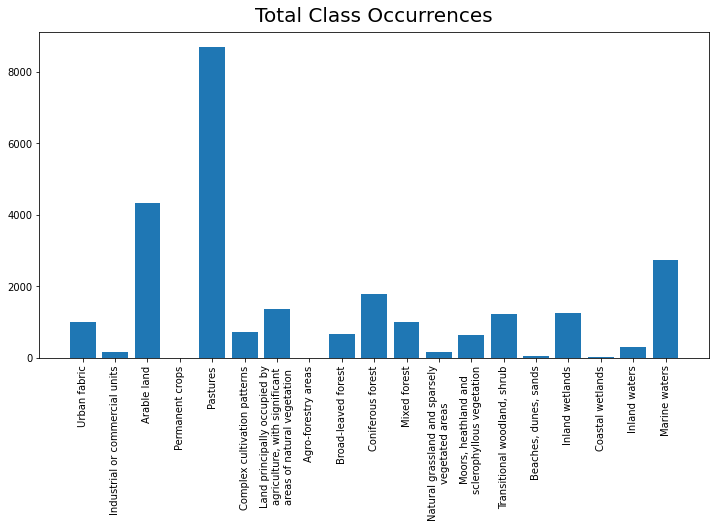

In [23]:
plt.figure(figsize=(12, 6))
plot_class_occurrences_count(y_true)

Mean Positive Label Count: 2.17
Var Positive Label Count: 1.25
Max Positive Label Count: 7
Min Positive Label Count: 1


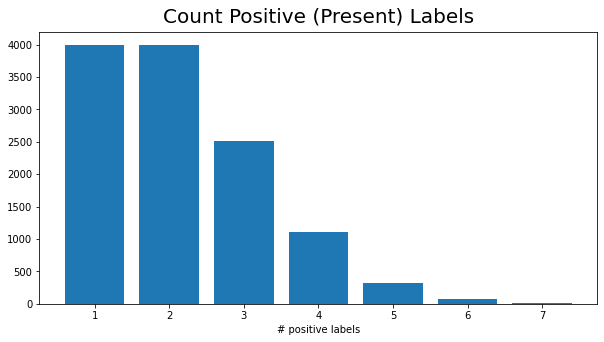

In [24]:
plt.figure(figsize=(10, 5))
plot_label_stats(y_true)

In [25]:
class_co_occurrences(y_true)

Total number of combinations of positive labels: 466

Most common combination: 
20.31% : Marine waters
18.70% : Arable land | Pastures
11.80% : Pastures
2.79% : Pastures | Coniferous forest
2.34% : Pastures | Land principally occupied by agriculture, with significant areas of natural vegetation
2.01% : Arable land | Pastures | Complex cultivation patterns
1.78% : Urban fabric | Arable land | Pastures
1.76% : Arable land | Pastures | Coniferous forest
1.25% : Arable land | Pastures | Mixed forest
1.20% : Pastures | Coniferous forest | Transitional woodland, shrub
1.12% : Pastures | Inland wetlands
1.07% : Pastures | Mixed forest
1.06% : Urban fabric | Pastures
1.02% : Pastures | Transitional woodland, shrub
0.89% : Arable land | Pastures | Land principally occupied by agriculture, with significant areas of natural vegetation
0.86% : Pastures | Complex cultivation patterns
0.84% : Arable land | Pastures | Broad-leaved forest
0.71% : Pastures | Land principally occupied by agriculture, wi

<Figure size 1008x1080 with 0 Axes>

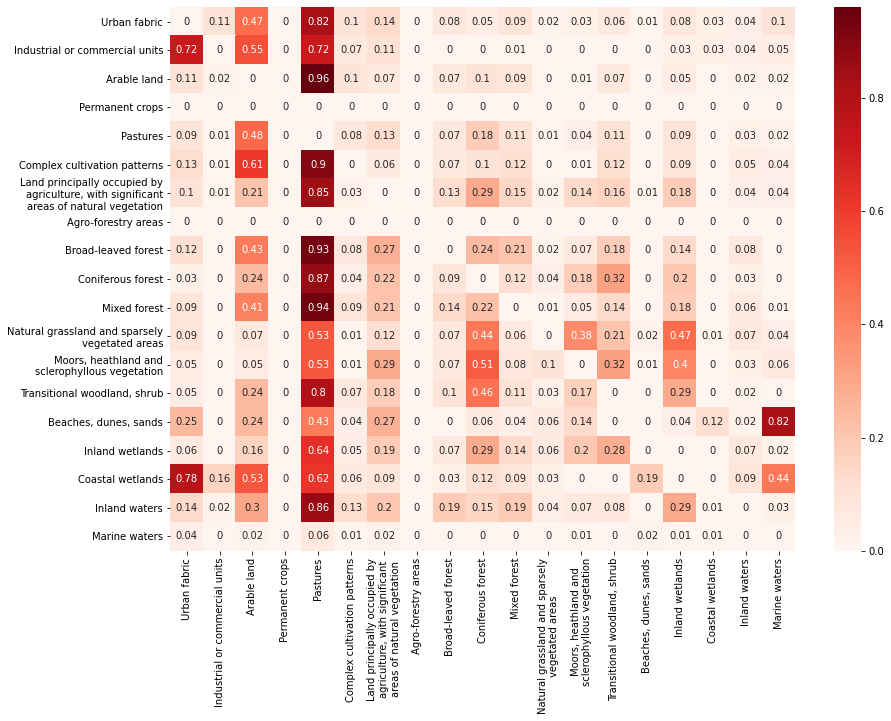

In [26]:
plt.figure(figsize=(14,15))
get_co_occurrence_heatmap(y_true)

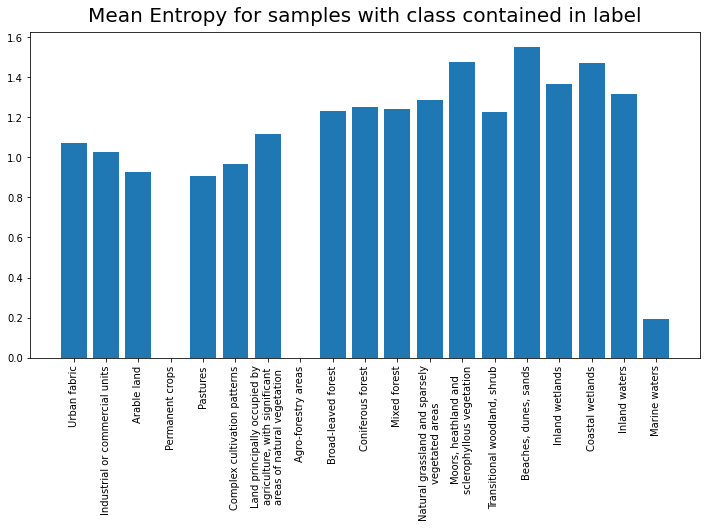

In [27]:
plt.figure(figsize=(12, 6))
plot_all_mean_entropies(y_true, predicted_probs)

### Mean Entropy for samples containing class C per # positive labels

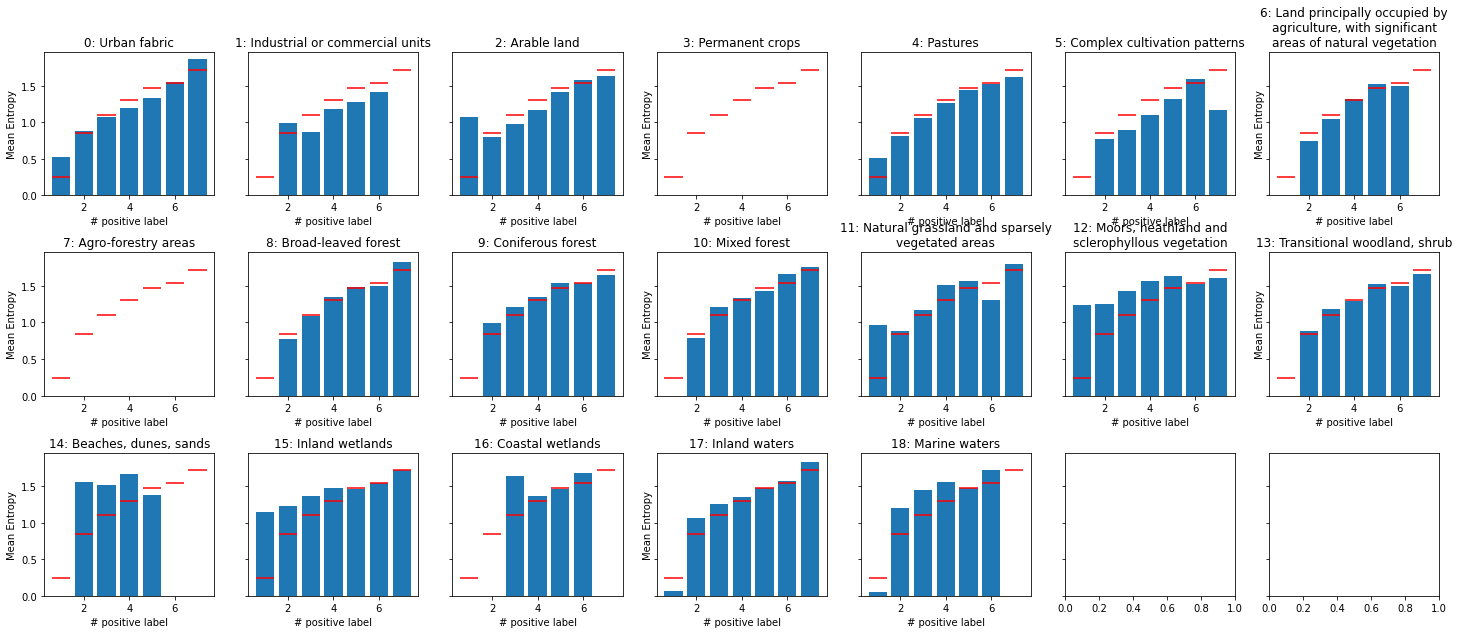

In [28]:
multiplot_classwise(plot_classwise_entropy, "Mean Entropy", True, y_true, predicted_probs)

Red Line: Mean Entropy for all datapoints with # positive labels (e.g. 2-label, 3-label etc.)

### Occurences for samples containing class C per # positive labels

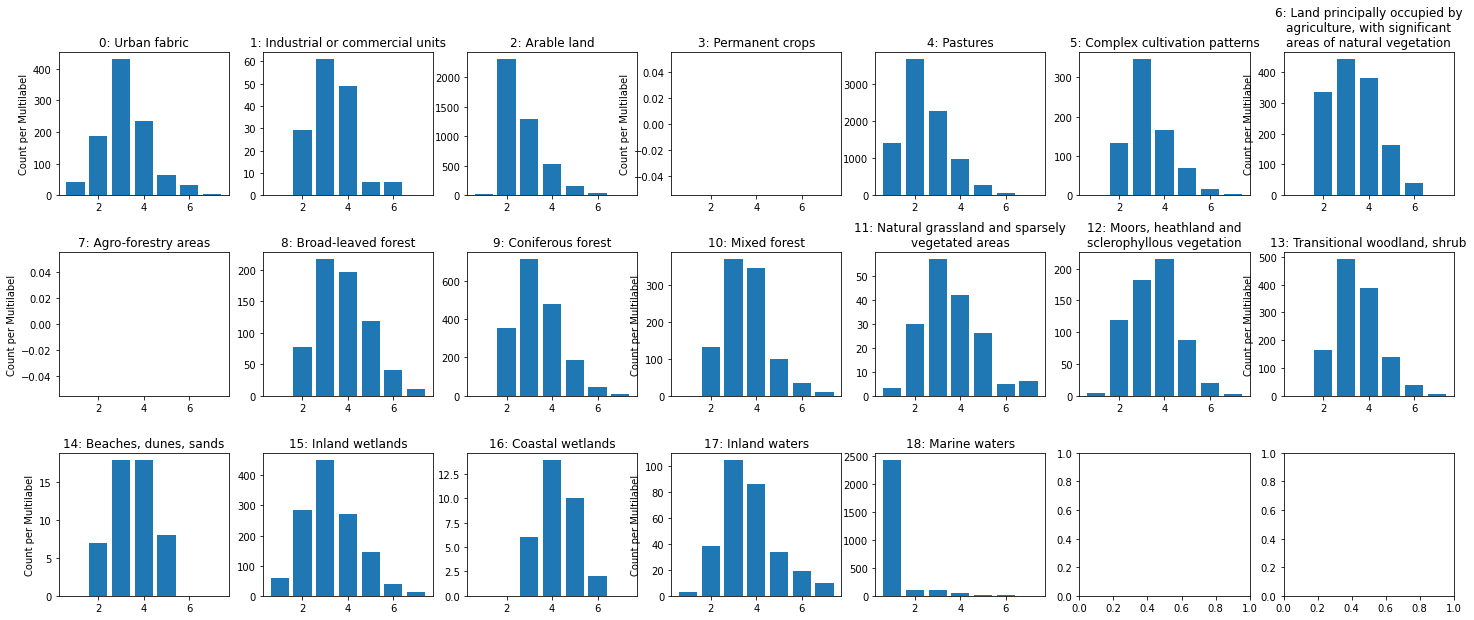

In [29]:
multiplot_classwise(plot_multilabel_classwise_count, "Count per Multilabel", False, y_true)

### Mean predicted probability of class C binned by # positive labels (when class is present in ground truth)

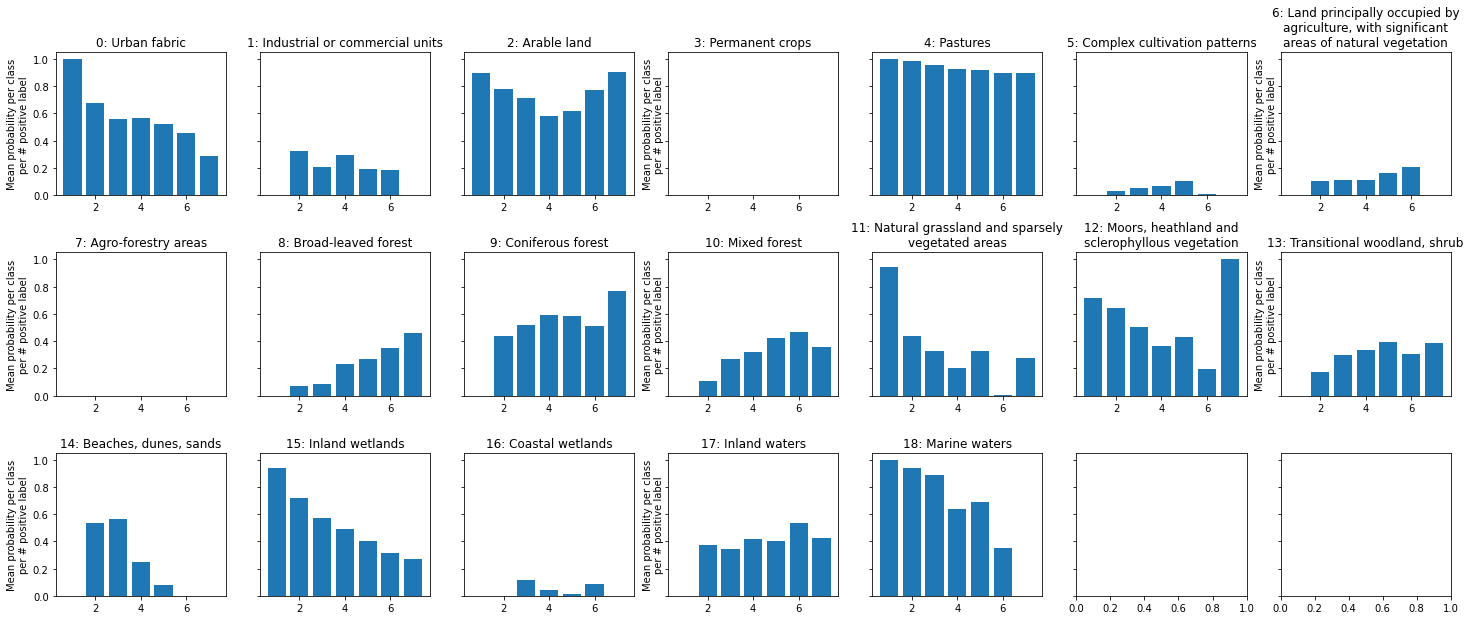

In [30]:
multiplot_classwise(plot_class_mean_probabilities, "Mean probability per class\nper # positive label", True,
                    y_true, predicted_probs)

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [32]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2)
pca_features50 = pca.fit_transform(representations)
tsne_features2 = tsne.fit_transform(pca_features50)

In [33]:
def plot_tsne_visualization(cls, y_true, tsne_features, ax=None):
    colors = list(map(lambda x: 'Green' if x[cls] == 1 else 'Gray', y_true))
    if ax:
        ax.scatter(tsne_features[:, 0], tsne_features[:, 1], c=colors[:], s=1, alpha=0.1)
        return ax
    else:
        plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=colors[:], s=1, alpha=0.1)

When rerunning t-SNE, do not be surprised by different clustering results. t-SNE is not stable by the embeddings it is producing! It is just a fancy first try for clustering.

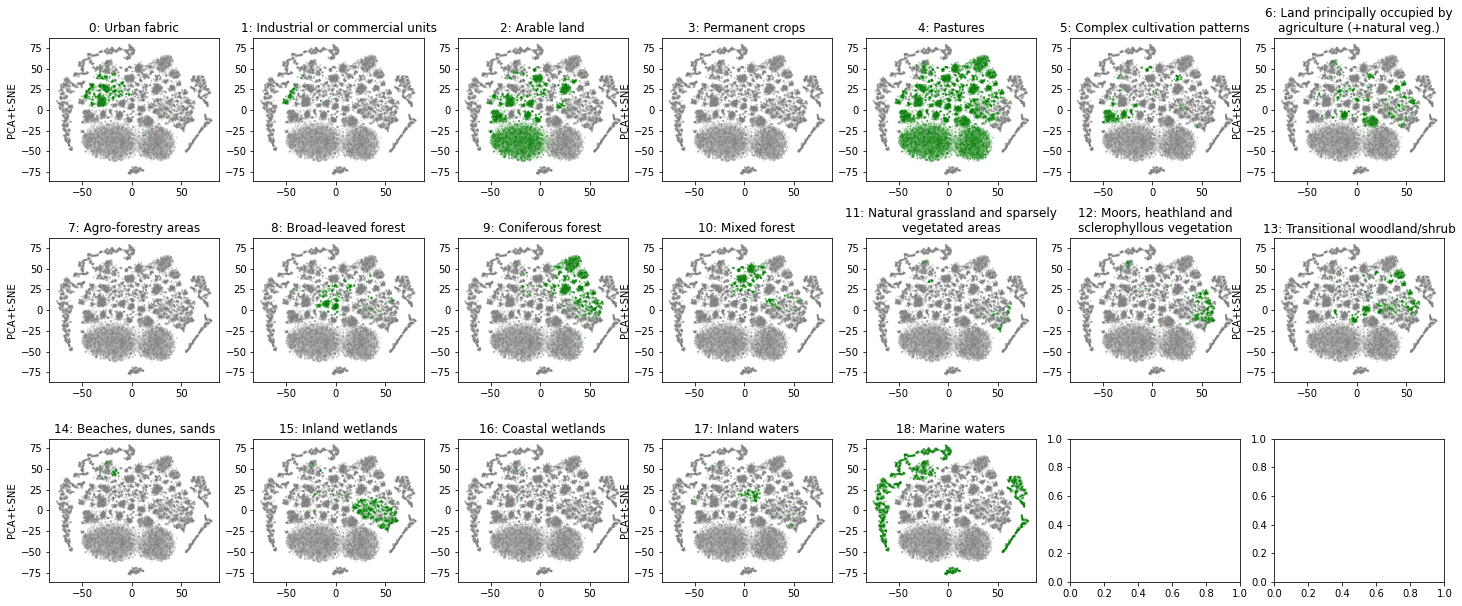

In [112]:
multiplot_classwise(plot_tsne_visualization, "PCA+t-SNE", False, y_true, tsne_features2)